# Example 1: Use of surface model Oh92 and canopy model SSRT

## 1. Requirements

- Installation of SenSE

## 2. Oh92+SSRT retrieval of soil moisture

In [1]:
import numpy as np
#from sense.surface import Dubois95, Oh92
from sense.util import f2lam
from sense.model import RTModel
from sense.soil import Soil
from sense.canopy import OneLayer
import matplotlib.pyplot as plt
import random
from sense.surface import Oh92, Oh04
from scipy.optimize import minimize
import pdb

/home/tweiss/anaconda3/envs/sense/lib/python3.10/site-packages/sense-0.1-py3.10.egg/sense/surface/i2em.py:282: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(cache=True)


In [2]:
#### Choose models
#-----------------
canopy = 'turbid_isotropic'
surface = 'Oh92'
models = {'surface' : surface, 'canopy' : canopy}
pol='vv'

In [3]:
# model parameter Oh92
#-----------------
freq = 5.405
clay = 0.0738
sand = 0.2408
bulk = 1.45
theta = np.deg2rad(35)
s = 0.013
sm = np.random.uniform(low=0.05, high=0.35, size=(50,))

In [4]:
# model parameter SSRT
#-----------------
d = 0.55
tau = 0.45
ke = tau/d
omega = 0.175
ks=omega*ke


In [5]:
# run model to produce backscatter
#-----------------
S = Soil(f=freq, s=s, mv=sm, sand=sand, clay=clay, bulk=bulk)
C = OneLayer(ke_h=ke, ke_v=ke, d=d, ks_v=ks, ks_h=ks, canopy=models['canopy'])
RT = RTModel(theta=theta, models=models, surface=S, canopy=C, freq=freq)
RT.sigma0()
back_vv = RT.stot['vv']
back_hv = RT.stot['hv']

In [6]:
# put uncertainty on backscatter
unc = np.random.uniform(low=-np.mean(back_vv)*0.15, high=np.mean(back_vv)*0.15, size=(len(back_vv),))
back_vv = back_vv - unc



In [7]:
# helper function retrieval
#-----------------
def run_model(dic, models):
    # surface
    soil = Soil(mv=dic['mv'], s=dic['s'], clay=dic['clay'], sand=dic['sand'], f=dic['f'], bulk=dic['bulk'])

    # canopy
    can = OneLayer(canopy=dic['canopy'], ke_h=dic['ke'], ke_v=dic['ke'], d=dic['d'], ks_h = dic['omega']*dic['ke'],
                   ks_v = dic['omega']*dic['ke'])

    S = RTModel(surface=soil, canopy=can, models=models, theta=dic['theta'], freq=dic['f'])
    S.sigma0()
    return S.__dict__['stot']['vv'[::-1]], S.__dict__['stot']['vh'[::-1]]

def solve_fun(VALS, var_opt, dic, models):

    for i in range(len(var_opt)):
        dic[var_opt[i]] = VALS[i]

    vv, vh = run_model(dic, models)

    return vv, vh

def fun_opt(VALS, var_opt, dic, models, pol):
    if pol == 'vv':
        return(np.nansum(np.square(solve_fun(VALS, var_opt, dic, models)[0]-dic['vv'])))
    elif pol == 'vh':
        return(np.nansum(np.square(solve_fun(VALS, var_opt, dic, models)[1]-dic['vh'])))
    elif pol == 'vv_vh':
        return(np.nansum(np.square((solve_fun(VALS, var_opt, dic, models)[0]-dic['vv'])/2+(solve_fun(VALS, var_opt, dic, models)[1]-dic['vh'])/2)))

In [8]:
# run soil moisture retrieval
#-----------------

dic = {"mv":0.2, "s":s, "clay":clay, "sand":sand, "f":freq, "bulk":bulk, "canopy":canopy, "d":d, 
       "ke":ke, "vv":back_vv, "vh":back_hv, "theta":theta, "omega": omega}

var_opt = ['mv']
guess = [0.2]
bounds = [(0.05,0.35)]

method = 'L-BFGS-B'

sm_retrieved = []

for i,ii in enumerate(back_vv):
    
    dic = {"mv":0.2, "s":s, "clay":clay, "sand":sand, "f":freq, "bulk":bulk, "canopy":canopy, "d":d, 
       "ke":ke, "vv":back_vv[i], "vh":back_hv[i], "theta":theta, "omega": omega}
    
    res = minimize(fun_opt,guess,args=(var_opt, dic, models, pol),bounds=bounds, method=method)

    fun_opt(res.x, var_opt, dic, models, 'vv')
    sm_retrieved.append(res.x[0])


In [88]:
diff = sm - sm_retrieved
diff_average = np.sum(abs(diff))/len(diff)
print(diff)
print(diff_average)

[-0.0651913   0.01847673  0.01705851  0.05645702 -0.06000856  0.00927838
 -0.03272987  0.06668285  0.01063583 -0.02355384 -0.0398816   0.02245182
  0.04245636 -0.06488275  0.0661784   0.03533185  0.03046308  0.02024597
  0.04207713  0.04917941  0.03684398  0.04597269 -0.04102686  0.01294052
  0.02575441  0.05677302  0.01754551 -0.00651102 -0.049835   -0.06548273
 -0.0248235  -0.01800793 -0.03792603 -0.01806101  0.05796109  0.05055889
  0.07824791 -0.02649838  0.01029102  0.00417659  0.04722087 -0.04987787
 -0.03668379  0.03377016 -0.05246246 -0.00699816 -0.01598757 -0.01970422
  0.03762196  0.0755702 ]
0.03668713261040448


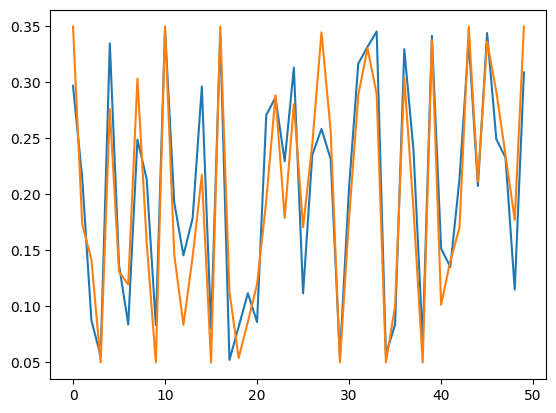

In [9]:
plt.plot(sm)
plt.plot(sm_retrieved)